In [1]:
import pandas as pd
import random
import numpy as np

In [2]:
features={"experience":0, "skills":1, "grades":2, "university":3, "requirements":4}
feature_range = {"experience": [0,1],
                 "skills":[0,1],
                 "grades": None ,
                 "university": ["ger-university", "net-university", "us-university", "nepotism-university", "bias-university"],
                 "requirements": [True, False],
                 }
feature_range_pointwise_shap = {"experience": [0,1],
                 "skills":[0,1],
                 "grades": None,
                 "university": [-1,10,2,1,3],
                 "requirements": [0, 1],
                 }
num_features = len(feature_range.keys())

grade_range = {uni: [4, 1] for uni in ["us-university", "nepotism-university", "bias-university"]}
grade_range["ger-university"] = [1, 4]
grade_range["net-university"] =  [10,6]

# Designing candidates from the search queries 

We design a set of candidates that will help us investige different ranking scenarios. 
- non-qualified-privileged: Candidate that does not meet the basic job requirements but comes from the priviledged nepotism-university
- non-qualified: Candidate that does not meet the basic job requirements, from a non-previledged us-university
- qualified-1, qualified-2, qualified-3: Candidates that meet the basic job requirements fromm us-university
- good-graduate: A candidate without any job experience but with good portfolio otherwise 
- qualified-biased: Candidate that does not meet the basic job requirements, from the bias-university, which the model is biased against
- qualified-net: Candidate that does not meet the basic job requirements, from a ger-university
- qualified-ger: Candidate that does not meet the basic job requirements, from a net-university


In [3]:
candidates = {
    "non-qualified-privileged" : [0.8, 0.6, 3.6, "nepotism-university", False],
    "non-qualified" : [0.7, 0.7, 3, "us-university", False],
    "qualified-1" : [0.8, 0.55, 3.5, "us-university", True],
    "qualified-2" : [0.7, 0.75, 3.3, "us-university", True],
    "qualified-3" : [0.9, 0.8, 3, "us-university", True],
    "good-graduate": [0, 0.9, 4, "us-university", True],
    "qualified-biased" : [0.8, 0.7, 3.6, "bias-university", True],
    "qualified-net": [0.7, 0.9, 8, "net-university", True],
    "qualified-ger": [0.8, 0.8, 1, "ger-university", True],
}

We transform the university fearture into a numeric feature to avoid mixed type arrays

In [4]:
numerical_university_values = {
    "ger-university": -1 , "net-university": 10, "us-university": 2, 
    "nepotism-university": 1, "bias-university": 3
    } 

def university_to_numerical(candidate): 
    candidate[features["university"]] =  numerical_university_values[candidate[features["university"]]]
    return candidate
candidates = {c: university_to_numerical(f) for c, f in candidates.items()}
candidates

{'non-qualified-privileged': [0.8, 0.6, 3.6, 1, False],
 'non-qualified': [0.7, 0.7, 3, 2, False],
 'qualified-1': [0.8, 0.55, 3.5, 2, True],
 'qualified-2': [0.7, 0.75, 3.3, 2, True],
 'qualified-3': [0.9, 0.8, 3, 2, True],
 'good-graduate': [0, 0.9, 4, 2, True],
 'qualified-biased': [0.8, 0.7, 3.6, 3, True],
 'qualified-net': [0.7, 0.9, 8, 10, True],
 'qualified-ger': [0.8, 0.8, 1, -1, True]}

In [5]:
grade_range = {numerical_university_values[university]: r for university, r in grade_range.items()}

# Sampling a set of background candidates

Since features can not be simply removed from the input to estimate the impact that each feature has on the different coalitions, a set of background candidates is being sampled that is used to mask the features that need to be hidden instead. Here we sample a set of 100 candidates that are randomly. All features are sampled uniforly within the corresponding range, assuming that the features are uncorrelated with each other. The grade feature is sampled dependent on the university that defines the range of the grades. 

In [6]:
def sample_candidates(samples):
    # a = ["prior_experience", "skills", "grades", "university", "meets_qualifications", "h-index", "job_title"]
    candidates = []

    for i in range(samples):
        candidate = {feature: random.choice(feature_range[feature]) for feature in ["university", "requirements"]}
        for feature in ["experience", "skills"]:
            candidate[feature] = random.uniform(feature_range[feature][0], feature_range[feature][1])
        if candidate["university"] in ["us-university", "nepotism-university", "bias-university"]:
            candidate["grades"] = random.uniform(1, 4)
        elif candidate["university"] == "ger-university":
            candidate["grades"] = random.uniform(1, 4)
        elif candidate["university"] == "net-university":
            candidate["grades"] = random.uniform(6, 10)
        candidates.append(candidate)
    return candidates


We sample 100 candidates.

In [7]:
background_samples = sample_candidates(100)
background_samples = pd.DataFrame(background_samples)
background_samples = background_samples[features.keys()]
background_samples = np.array(background_samples)
background_samples = np.array([university_to_numerical(b) for b in background_samples])

# Designing the query scenarios

We design the following scenarios to evaluate the different explanation approaches on: 

In [8]:
query_candidates = {
    "Average" : ["non-qualified",  "qualified-1", "qualified-2"],
    "Nepotism" : ["non-qualified-privileged", "non-qualified", "qualified-1", "qualified-2"],
    "Qualified" : ["qualified-1", "qualified-2", "qualified-3"],
    "International": ["qualified-net","qualified-ger", "qualified-3", "non-qualified"],
    "Neg biased": ["qualified-biased", "non-qualified", "qualified-1", "qualified-2"]#,
    #"good-graduate": ["qualified-3",  "qualified-1", "qualified-2", "good-graduate"]
}

In [9]:
queries = {query: [candidates[candidate_name] for candidate_name in candidate_names] for query, candidate_names in query_candidates.items()}
queries

{'Average': [[0.7, 0.7, 3, 2, False],
  [0.8, 0.55, 3.5, 2, True],
  [0.7, 0.75, 3.3, 2, True]],
 'Nepotism': [[0.8, 0.6, 3.6, 1, False],
  [0.7, 0.7, 3, 2, False],
  [0.8, 0.55, 3.5, 2, True],
  [0.7, 0.75, 3.3, 2, True]],
 'Qualified': [[0.8, 0.55, 3.5, 2, True],
  [0.7, 0.75, 3.3, 2, True],
  [0.9, 0.8, 3, 2, True]],
 'International': [[0.7, 0.9, 8, 10, True],
  [0.8, 0.8, 1, -1, True],
  [0.9, 0.8, 3, 2, True],
  [0.7, 0.7, 3, 2, False]],
 'Neg biased': [[0.8, 0.7, 3.6, 3, True],
  [0.7, 0.7, 3, 2, False],
  [0.8, 0.55, 3.5, 2, True],
  [0.7, 0.75, 3.3, 2, True]]}

# The ranking model

In [10]:
def ranking_model(feature_vectors, biased=True): #feature_vector must be a np.array
    ranking_scores = []
    single_input = False
    if len(np.array(feature_vectors).shape) == 1 or np.array(feature_vectors).shape[1] == 0:
        feature_vectors = [feature_vectors]
        single_input = True
    for feature_vector in feature_vectors:
        ranking_score = feature_vector[features["skills"]] + feature_vector[features["experience"]]
        normalized_grade = feature_vector[features["grades"]]
        
        # Add a bias, normalize grades based on system.
        g_range = grade_range[feature_vector[features["university"]]]
        if g_range[0] < g_range[1]:
            normalized_grade = (g_range[1] - normalized_grade)/ (g_range[1]-g_range[0])
        else:
            normalized_grade = (normalized_grade - g_range[1])/ (g_range[0]-g_range[1])
        ranking_score += normalized_grade
    
        if biased and feature_vector[features["university"]] == 3:
            ranking_score = ranking_score * 0.9

        if not feature_vector[features["requirements"]] == 1:
            if not (feature_vector[features["university"]] == 1 and biased):
                ranking_score = ranking_score * 0.25
        ranking_scores.append(ranking_score)
    if single_input:
        return ranking_scores[0]
    return np.array(ranking_scores)


In [11]:
for name, query in queries.items(): 
    print(name, ": ", ranking_model(np.array(query)))

Average :  [0.51666667 2.18333333 2.21666667]
Nepotism :  [2.26666667 0.51666667 2.18333333 2.21666667]
Qualified :  [2.18333333 2.21666667 2.36666667]
International :  [2.1        2.6        2.36666667 0.51666667]
Neg biased :  [2.13       0.51666667 2.18333333 2.21666667]


# Generating explanations for each scenario 

We generate explanations for the query scenarios. We investigate the biased model first. For investigating the unbiased model instead, uncomment the 7. line in the code. 

In [12]:
import shap
import numpy as np
from utils.helper_functions import rank_list
from utils.explanation import AttributionExplanation

class AggregatedShap:
    def __init__(
        self,
        background_data,
        model,
        explanation_size=3,
        name="",
        aggregate_over_top=5,
        nsamples=2**10,
        normalize=True
    ):
        self.background_data = background_data
        self.explanation_size = explanation_size
        self.name = name
        self.num_features = len(background_data[0])
        self.nsamples = nsamples
        self.model = model
        self.aggregate_over_top = aggregate_over_top
        self.normalize = normalize

    def get_query_explanation(self, query_features, query_id=""):
        background_summary = shap.sample(
            self.background_data, 100
        )  # create summary of background data

        shap_explainer = shap.KernelExplainer(self.model, background_summary)
        pred = self.model(query_features)

        og_rank = rank_list(pred)

        exp_dict = {i: 0 for i in range(self.num_features)}

        if type(self.aggregate_over_top) == tuple: 
            l,r = self.aggregate_over_top
            r = min(r, len(og_rank)) + 1
        else: 
            l = 1 
            r = min(self.aggregate_over_top, len(og_rank)) + 1

        # Get aggregated importance of each feature for first few documents
        for j in range(l, r):
            best_doc_ind = np.where(og_rank == j)[0][0]

            exp = shap_explainer.shap_values(
                np.array(query_features[best_doc_ind]), nsamples=self.nsamples
            )
            exp_dict = {
                feature: exp_dict.get(feature, 0) + value
                for feature, value in enumerate(exp)
            }
        if self.normalize: 
            try:
                # Normalize to 1 to make it better comparable with other methods.
                exp_dict = {
                    feature: exp_dict[feature] / sum(exp_dict.values())
                    for feature in exp_dict
                }
            except:
                exp_dict = exp_dict
        explanation = sorted(exp_dict.items(), key=lambda item: item[1], reverse=True)
        feature_attributes = AttributionExplanation(
            explanation=explanation, num_features=self.num_features, query_id=query_id
        )
        feature_selection = feature_attributes.get_top_k_feature_selection(
            self.explanation_size
        )
        return feature_selection, feature_attributes


/home/nina/Documents/REPR-RankingShap/rshap/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
from approaches.ranking_shap import RankingShap
from approaches.greedy_listwise import GreedyListwise
from scipy.stats import kendalltau
from approaches.ranking_lime import RankingLIME
from functools import partial 

ranking_model_ = partial(ranking_model, biased=True) 

rank_similarity_coefficient = lambda x,y: kendalltau(x,y)[0]
explanation_size = 5

ranking_shap_explainer = RankingShap(
    permutation_sampler="kernel",
    background_data=background_samples,
    original_model=ranking_model_,
    explanation_size=num_features,
    name="rankingshap_no_weighting",
    rank_similarity_coefficient=rank_similarity_coefficient
)


greedy_explainer_iter = GreedyListwise(
    background_data=background_samples,
    model=ranking_model_,
    explanation_size=2,
    name="greedy_listwise_iter",
    feature_attribution_method="iter",
    mixed_type_input=True
)


aggregated_shap_explainer = AggregatedShap(
    background_data=background_samples,
    model=ranking_model_,
    explanation_size=num_features,
    name="aggregated_shap_top_5",
    aggregate_over_top=5,
    # normalize=True
)

explainers = [ranking_shap_explainer, greedy_explainer_iter, aggregated_shap_explainer]


In [14]:
explanation_dfs = {}
for explainer in explainers:
    explanations = {}
    for current_query in queries:
        features_selection, feature_attribution = explainer.get_query_explanation(query_features=queries[current_query], query_id=current_query)
        rankingscores = [ranking_model(candidate) for candidate in queries[current_query]]
        explanations[current_query] = feature_attribution
    results = pd.DataFrame({ex_name: {expl[0]: expl[1] for expl in ex.explanation} for ex_name, ex  in explanations.items()}).sort_index()
    results["features"] = list(features.keys())
    results = results.set_index("features")
    if explainer.name == "greedy_listwise_iter":
         results = results.map(lambda x: 1 if x > 0 else 0)
    results.to_csv(f"results/{explainer.name}_syn.csv")
    explanation_dfs[explainer.name]  = results


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


In [15]:
explanation_dfs = pd.concat(explanation_dfs, names=['approach'])

In [16]:
#explanation_dfs.drop(columns=['Nepotism', 'International'], inplace=True)

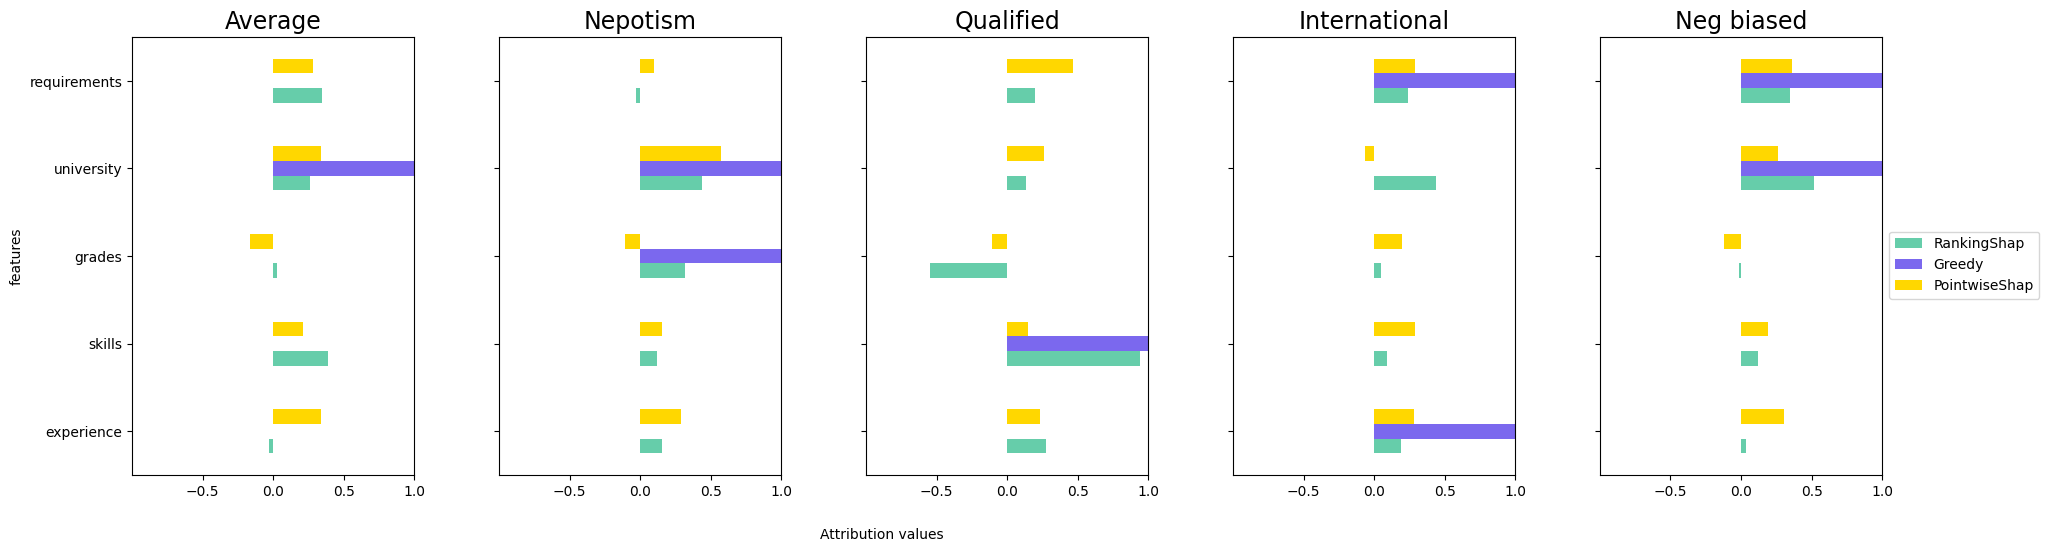

In [17]:
import matplotlib.pyplot as plt

line_labels = ["RankingShap", "Greedy", "PointwiseShap"]

fig, ax = plt.subplots(1, 5, figsize=(20, 6), sharey=True)

for i, column in enumerate(explanation_dfs.columns): 
    e = explanation_dfs[column].unstack(level=0)
    e.plot(kind='barh', color=['mediumaquamarine', 'mediumslateblue', 'gold'], ax=ax[i], legend=False)
    
    # 1. Force specific limits and ticks
    ax[i].set_xlim(-1, 1)
    ax[i].set_xticks([-0.5, 0, 0.5, 1.0]) # This prevents "too many ticks"
    
    ax[i].set_title(column, size=17)
    
    # Clean up Y-labels (only show on the first plot)
    if i > 0:
        ax[i].set_ylabel("")

# 2. Add the shared X-label at the bottom middle
fig.text(0.5, 0.05, 'Attribution values', ha='center', va='center', fontsize=10)

# 3. Add the legend on the right
fig.legend(labels=line_labels, loc='center left', bbox_to_anchor=(1.0, 0.5))

# 4. Use subplots_adjust instead of tight_layout for finer control
# 'right' makes room for the legend; 'bottom' makes room for your fig.text
plt.subplots_adjust(right=1, bottom=0.15, wspace=0.3) 

plt.show()

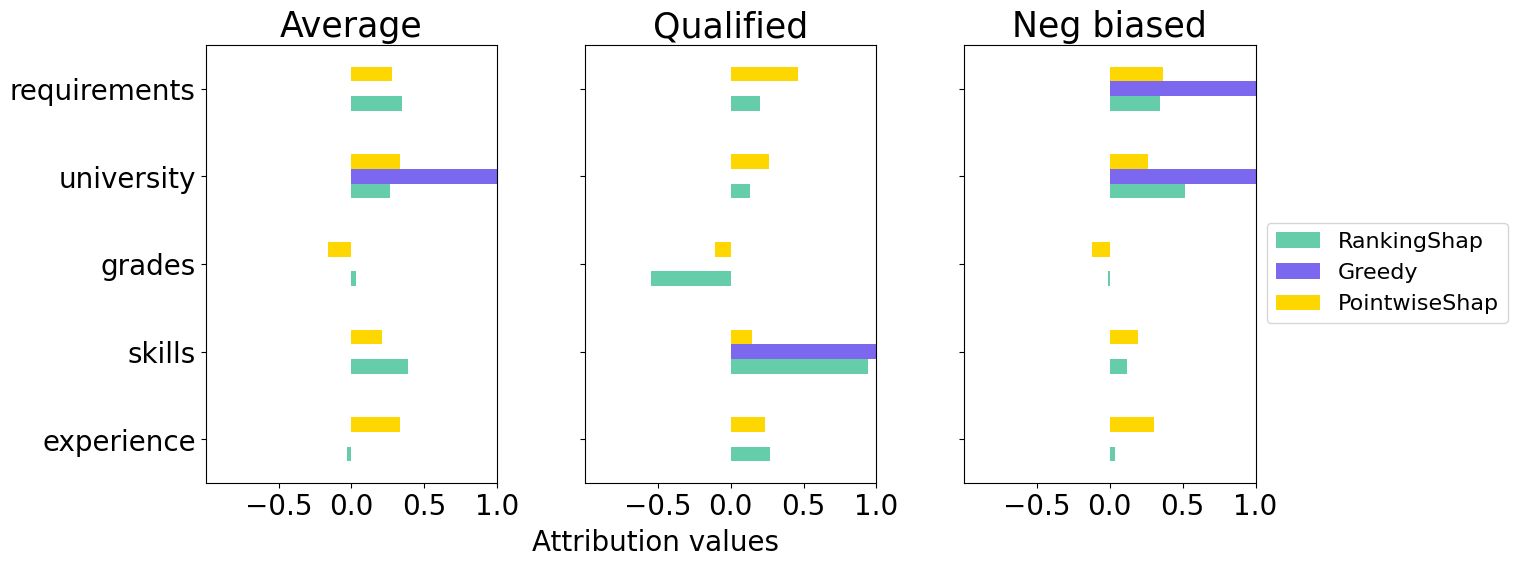

In [18]:
explanation_dfs.drop(columns=['Nepotism', 'International'], inplace=True)
line_labels = ["RankingShap", "Greedy", "PointwiseShap"]

fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

for i, column in enumerate(explanation_dfs.columns): 
    e = explanation_dfs[column].unstack(level=0)
    e.plot(kind='barh', color=['mediumaquamarine', 'mediumslateblue', 'gold'], ax=ax[i], legend=False)
    
    # 1. Force specific limits and ticks
    ax[i].set_xlim(-1, 1)
    ax[i].set_xticks([-0.5, 0, 0.5, 1.0]) # This prevents "too many ticks"
    ax[i].tick_params(axis='both', which='major', labelsize=20)
    ax[i].set_ylabel("")
    ax[i].set_title(column, size=25)
    
    # Clean up Y-labels (only show on the first plot)
    if i > 0:
        ax[i].set_ylabel("")

# 2. Add the shared X-label at the bottom middle
fig.text(0.5, 0.05, 'Attribution values', ha='center', va='center', fontsize=20)

# 3. Add the legend on the right
fig.legend(labels=line_labels, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=16)

# 4. Use subplots_adjust instead of tight_layout for finer control
# 'right' makes room for the legend; 'bottom' makes room for your fig.text
plt.subplots_adjust(right=1, bottom=0.15, wspace=0.3) 

plt.show()

## Using other explanation objectives 

To zoom in to the individual documents and the role that the features play in providing those documents with high exposure, we define a explanation objective that measures the exposure of a document in the ranked list and use this for generating explanations for each indiviudal document: 

In [19]:
def first_vs_all_silimarity(base_ranks_1, adjusted_ranks_2, rank_to_compare = 1):
    if rank_to_compare > len(list(base_ranks_1)): 
        return 0 
    list_index_rank_1 = list(base_ranks_1).index(rank_to_compare)
    return 1/ np.log2(1 + adjusted_ranks_2[list_index_rank_1])



In [20]:
ranking_shap_explainer_first_vs_all = RankingShap(
    permutation_sampler="kernel",
    background_data=background_samples,
    original_model=ranking_model_,
    explanation_size=num_features,
    name="rankingshap_first_vs_all",
    rank_similarity_coefficient=first_vs_all_silimarity
)

ranking_shap_explainer_second_vs_all = RankingShap(
    permutation_sampler="kernel",
    background_data=background_samples,
    original_model=ranking_model_,
    explanation_size=num_features,
    name="rankingshap_second_vs_all",
    rank_similarity_coefficient=partial(first_vs_all_silimarity, rank_to_compare=2)
)

ranking_shap_explainer_third_vs_all = RankingShap(
    permutation_sampler="kernel",
    background_data=background_samples,
    original_model=ranking_model_,
    explanation_size=num_features,
    name="rankingshap_third_vs_all",
    rank_similarity_coefficient=partial(first_vs_all_silimarity, rank_to_compare=3)
)

ranking_shap_explainer_forth_vs_all = RankingShap(
    permutation_sampler="kernel",
    background_data=background_samples,
    original_model=ranking_model_,
    explanation_size=num_features,
    name="rankingshap_forth_vs_all",
    rank_similarity_coefficient=partial(first_vs_all_silimarity, rank_to_compare=4)
)


In [21]:
explainers = [ranking_shap_explainer_first_vs_all, ranking_shap_explainer_second_vs_all, ranking_shap_explainer_third_vs_all, ranking_shap_explainer_forth_vs_all]
explanation_dfs = {}
for explainer in explainers:
    explanations = {}
    for current_query in queries:
        features_selection, feature_attribution = explainer.get_query_explanation(query_features=queries[current_query], query_id=current_query)
        rankingscores = [ranking_model(candidate) for candidate in queries[current_query]]
        explanations[current_query] = feature_attribution
    results = pd.DataFrame({ex_name: {expl[0]: expl[1] for expl in ex.explanation} for ex_name, ex  in explanations.items()}).sort_index()
    results["features"] = list(features.keys())
    results = results.set_index("features")
    results.to_csv(f"results/{explainer.name}_syn.csv")
    explanation_dfs[explainer.name]  = results


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


In [22]:
a = pd.concat(explanation_dfs, names=['approach'])

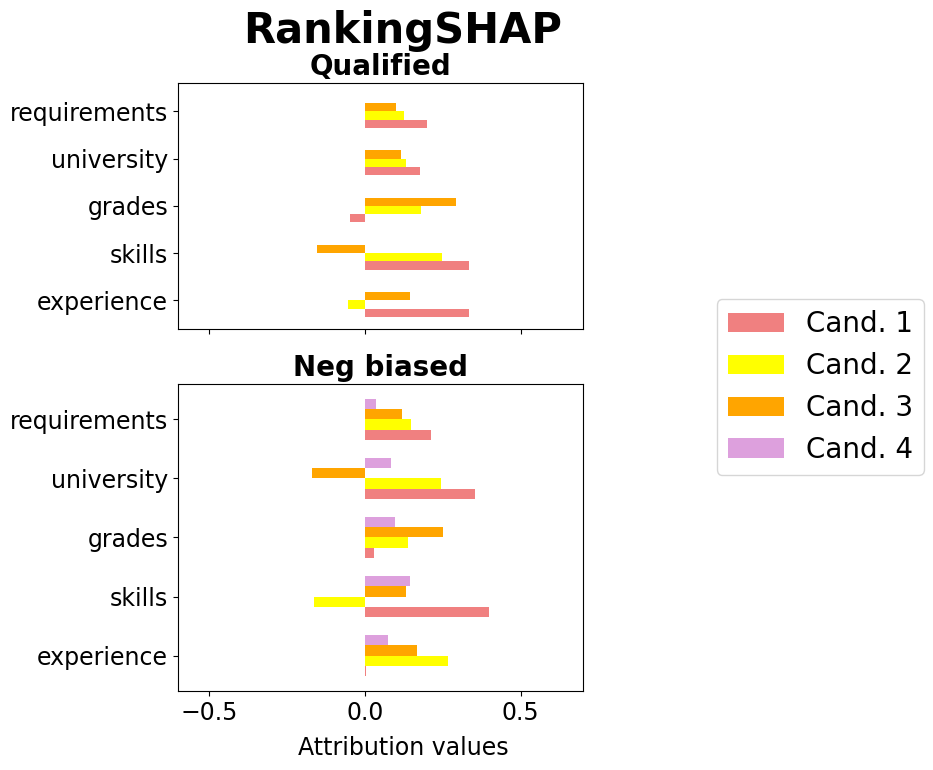

In [23]:
import matplotlib.pyplot as plt

# Define the scenarios and labels
target_scenarios = ["Qualified", "Neg biased"] 
line_labels = ["Cand. 1", "Cand. 2", "Cand. 3", "Cand. 4"]

# 1. Use gridspec_kw to set height ratios (e.g., 1:2 means the bottom is twice as tall)
fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True, 
                         gridspec_kw={'height_ratios': [1.2, 1.5]})

for i, scenario in enumerate(target_scenarios):
    if scenario in a.columns:
        e = a[scenario].unstack(level=0)
        
        e.plot(kind='barh', 
               color=['lightcoral', 'yellow', 'orange', 'plum'], 
               ax=axes[i], 
               legend=False, 
               width=0.7)
        
        # Formatting titles to match your reference image style
        axes[i].set_title(scenario, fontweight='bold', fontsize=20)
        axes[i].set_xlim(-0.6, 0.7)
        axes[i].set_xticks([-0.5, 0, 0.5])
        axes[i].tick_params(axis='both', which='major', labelsize=17)
        axes[i].set_ylabel("") 
    else:
        print(f"Scenario '{scenario}' not found.")

fig.text(0.5, 0.93, 'RankingSHAP', ha='center', fontweight='bold',fontsize=30)
# 2. Add shared X-axis label centered at the bottom
fig.text(0.5, 0.04, 'Attribution values', ha='center', fontsize=17)

# 3. Add the shared legend on the right side
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, line_labels, loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=True, fontsize=20)

# 4. Adjust layout
# hspace=0.4 adds vertical padding so titles don't overlap the plot above
plt.subplots_adjust(right=0.8, bottom=0.12, hspace=0.2)

plt.show()

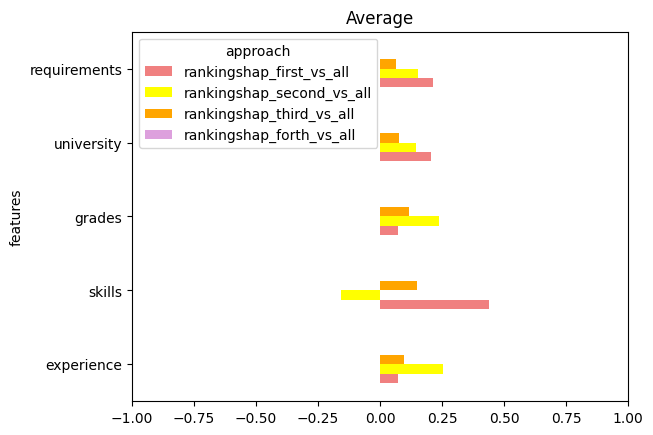

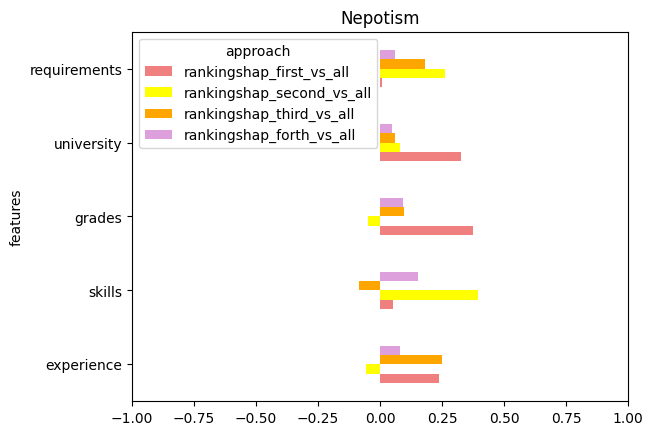

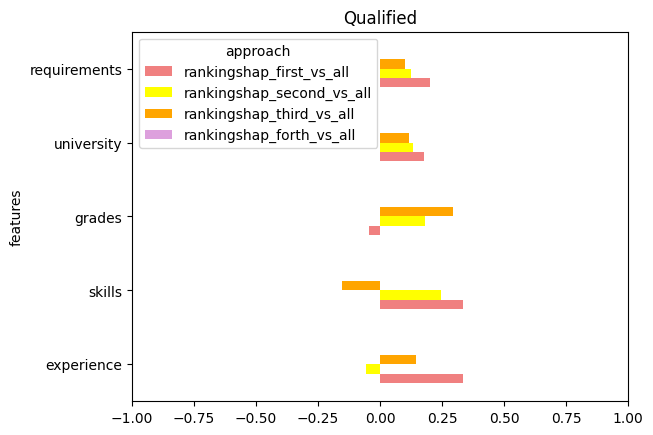

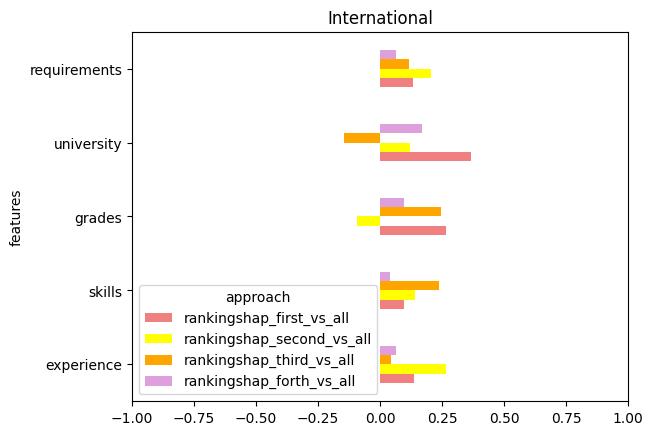

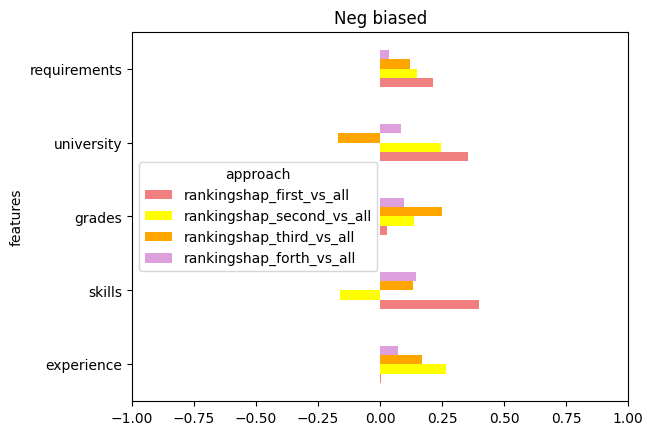

In [24]:
explanation_dfs = pd.concat(explanation_dfs, names=['approach'])
import matplotlib.pyplot as plt
for column in explanation_dfs.columns: 
    e = explanation_dfs[column].unstack(level=0)
    e.plot(kind='barh', color=['lightcoral', 'yellow', 'orange', 'plum'])
    plt.xlim(-1, 1)
    plt.title(column)
    plt.show()

We compare to the pointwise SHAP explainer, that aims to explain why a document has received a high ranking score: 

In [25]:
pointwise_shap_explainer_1 = AggregatedShap(
    background_data=background_samples,
    model=ranking_model_,
    explanation_size=num_features,
    name="pointwise_shap_1",
    aggregate_over_top=(1,1),
    normalize=False
)

pointwise_shap_explainer_2 = AggregatedShap(
    background_data=background_samples,
    model=ranking_model_,
    explanation_size=num_features,
    name="pointwise_shap_2",
    aggregate_over_top=(2,2),
    normalize=False
)

pointwise_shap_explainer_3 = AggregatedShap(
    background_data=background_samples,
    model=ranking_model_,
    explanation_size=num_features,
    name="pointwise_shap_3",
    aggregate_over_top=(3,3),
    normalize=False
)

pointwise_shap_explainer_4 = AggregatedShap(
    background_data=background_samples,
    model=ranking_model_,
    explanation_size=num_features,
    name="pointwise_shap_4",
    aggregate_over_top=(4,4),
    normalize=False
)

In [26]:
explainers = [pointwise_shap_explainer_1, pointwise_shap_explainer_2, pointwise_shap_explainer_3, pointwise_shap_explainer_4]
explanation_dfs = {}
for explainer in explainers:
    explanations = {}
    for current_query in queries:
        features_selection, feature_attribution = explainer.get_query_explanation(query_features=queries[current_query], query_id=current_query)
        # features_selection, feature_attribution = explainer.get_query_explanation(query_features=np.array(queries[current_query]), query_id=current_query)
        rankingscores = [ranking_model(candidate) for candidate in queries[current_query]]
        explanations[current_query] = feature_attribution
    results = pd.DataFrame({ex_name: {expl[0]: expl[1] for expl in ex.explanation} for ex_name, ex  in explanations.items()}).sort_index()
    results["features"] = list(features.keys())
    results = results.set_index("features")
    results.to_csv(f"results/{explainer.name}_syn.csv")
    explanation_dfs[explainer.name]  = results

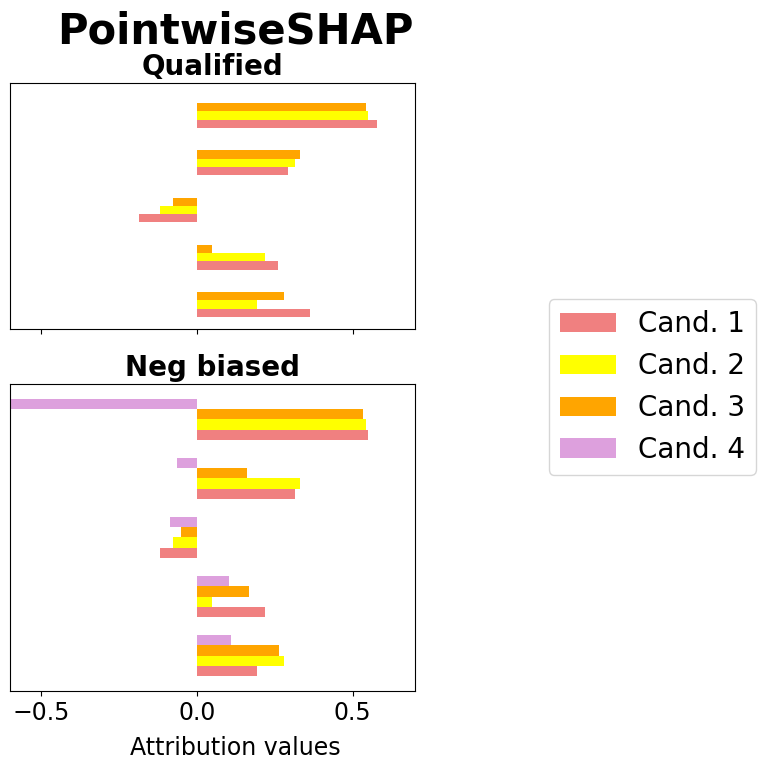

In [27]:
a = pd.concat(explanation_dfs, names=['approach'])

# Define the scenarios and labels
target_scenarios = ["Qualified", "Neg biased"] 
line_labels = ["Cand. 1", "Cand. 2", "Cand. 3", "Cand. 4"]

# 1. Use gridspec_kw to set height ratios (e.g., 1:2 means the bottom is twice as tall)
fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True, 
                         gridspec_kw={'height_ratios': [1.2, 1.5]})

for i, scenario in enumerate(target_scenarios):
    if scenario in a.columns:
        e = a[scenario].unstack(level=0)
        
        e.plot(kind='barh', 
               color=['lightcoral', 'yellow', 'orange', 'plum'], 
               ax=axes[i], 
               legend=False, 
               width=0.7)
        
        # Formatting titles to match your reference image style
        axes[i].set_title(scenario, fontweight='bold', fontsize=20)
        axes[i].set_xlim(-0.6, 0.7)
        axes[i].set_xticks([-0.5, 0, 0.5])
        axes[i].set_yticks([])
        axes[i].tick_params(axis='both', which='major', labelsize=17)
        axes[i].set_ylabel("") 
    else:
        print(f"Scenario '{scenario}' not found.")

fig.text(0.5, 0.93, 'PointwiseSHAP', ha='center', fontweight='bold',fontsize=30)
# 2. Add shared X-axis label centered at the bottom
fig.text(0.5, 0.04, 'Attribution values', ha='center', fontsize=17)

# 3. Add the shared legend on the right side
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, line_labels, loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=True, fontsize=20)

# 4. Adjust layout
# hspace=0.4 adds vertical padding so titles don't overlap the plot above
plt.subplots_adjust(right=0.8, bottom=0.12, hspace=0.2)

plt.show()

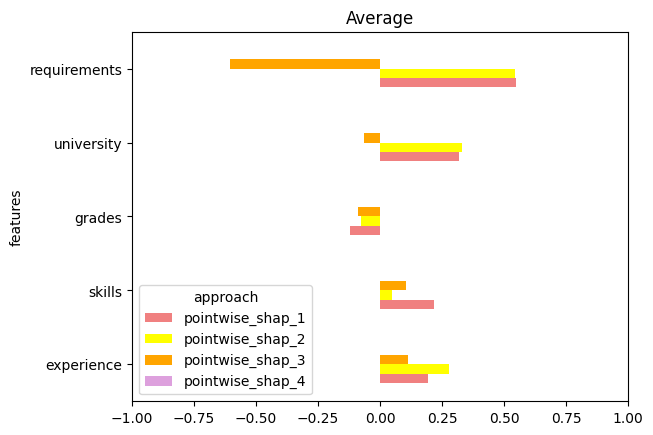

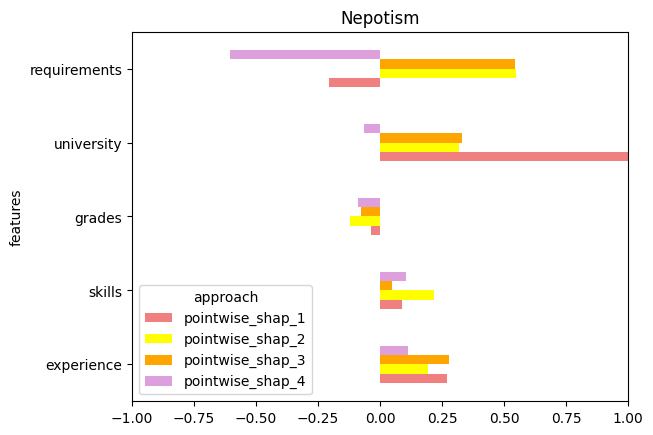

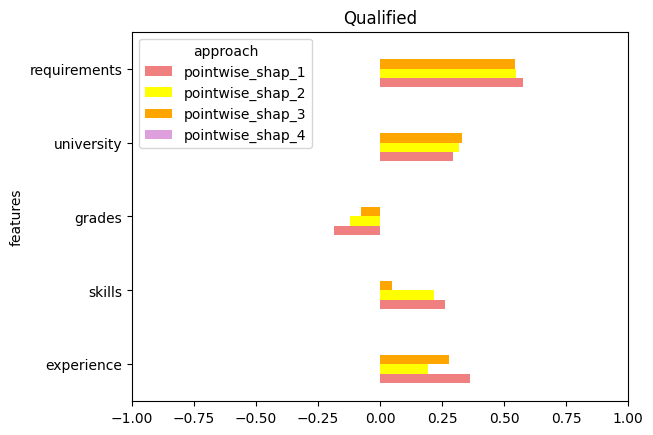

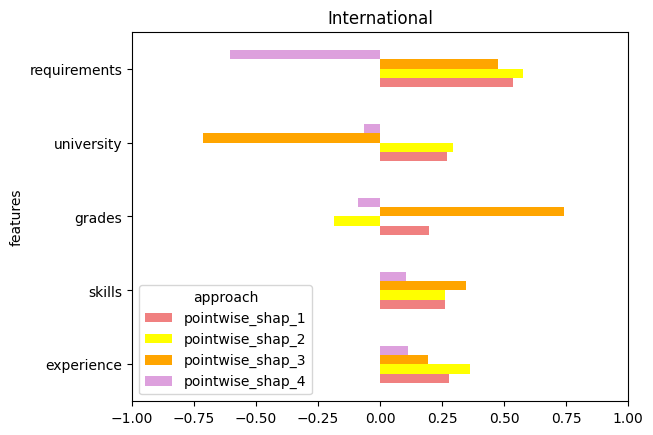

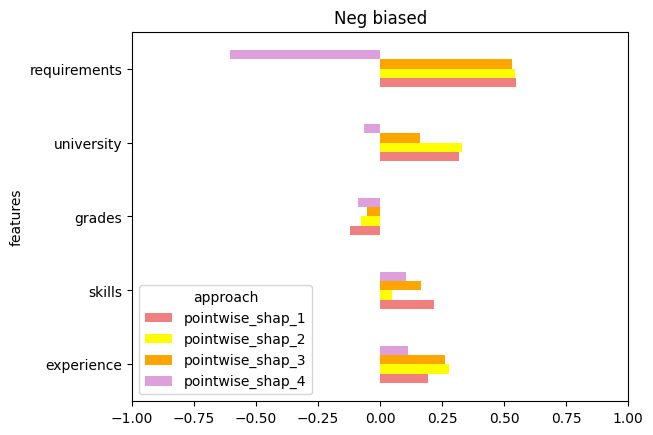

In [29]:
explanation_dfs = pd.concat(explanation_dfs, names=['approach'])
# explanation_dfs = scaled_df
import matplotlib.pyplot as plt
for column in explanation_dfs.columns: 
    e = explanation_dfs[column].unstack(level=0)
    e.plot(kind='barh', color=['lightcoral', 'yellow', 'orange', 'plum'])
    plt.xlim(-1, 1)
    plt.title(column)
    plt.show()